# AI Text Classifier - Model Builder

## Description

The AI Text Classifier is a lightweight tool designed to classify text into predefined categories. It uses machine learning algorithms to learn from labeled datasets and predicts the category for new, unseen text inputs. This project aims to build a functional classifier that can be integrated with AWS Lambda, demonstrating practical experience in AI, Python development, and serverless architecture. The tool is suitable for small-scale, low-latency use cases such as automated email filtering, sentiment monitoring for customer feedback, or simple content moderation tasks.

For this project, a Kaggle database containing prelabeled SMS text messages will be used to train the classifier to mark text messages as either spam or ham (not spam). It is important to note that this dataset is highly imbalanced (4825 ham/747 spam --> 86.59% ham/13.41% spam), so additional steps will be needed when building and evaluating the model (Stratified K-Fold Cross Validation).

## Setup

### 1. Install Required Packages

In [ ]:
!python -m pip install -r Resources/requirements.txt

### 2. Import Required Libraries and Modules

In [1]:
import numpy as np          # For numerical operations
import pandas as pd         # For data import and manipulation
import tensorflow as tf     # For deep learning model
import pickle               # For saving the tokenizer

#### A. Import Functionality for Building Training and Validation Data Sets

In [2]:
from sklearn.model_selection import StratifiedKFold         # For cross-validation
from sklearn.feature_extraction.text import TfidfVectorizer # For converting text data into numerical data
from sklearn import preprocessing                           # For encoding the target variable
from sklearn.metrics import accuracy_score                  # For evaluating the model

#### B. Import Functionality for Plotting Graphs

In [3]:
import matplotlib.pyplot as plt                 # For plotting the model performance

## Data Pre-Processing

Text data needs to be converted to numeric representations before it can be used to train deep learning models.

The SMS classification feature data is converted to numerical representation using Term Frequency–Inverse Document Frequency (TF-IDF) encoding. Then, the target variable is converted to one-hot encoding.

Perform the following steps for preparing data:

1. Load data into a pandas dataframe
2. Vectorize and scale the data using TF-IDF encoding
3. Convert the dataframe to a numpy array

These last two steps are done later in the model training step:

4. Use one-hot-encoding for the target variable
5. Split into training and test datasets

### Import Raw Data

In [4]:
# Load SMS spam data into a pandas dataframe and output for review
# NOTE: The data is not "UTF-8" format. Trying to specify the encoding as "ISO-8859-1"
spam_data = pd.read_csv("Resources/spam.csv", encoding="ISO-8859-1")

# Separate the feature and target data
spam_classifications_raw = spam_data["v1"]
spam_messages = spam_data["v2"]

print(spam_data.head())
print(spam_classifications_raw.head())

     v1                                                 v2 Unnamed: 2 Unnamed: 3 Unnamed: 4
0   ham  Go until jurong point, crazy.. Available only ...        NaN        NaN        NaN
1   ham                      Ok lar... Joking wif u oni...        NaN        NaN        NaN
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN        NaN        NaN
3   ham  U dun say so early hor... U c already then say...        NaN        NaN        NaN
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN        NaN        NaN
0     ham
1     ham
2    spam
3     ham
4     ham
Name: v1, dtype: object


### Create Numeric Representations

In [5]:
from Resources.CustomTokenizer import Custom_Tokenizer 

# Build a TF-IDF Vectorizer model
tokenizer_Instance = Custom_Tokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer_Instance.custom_tokenizer)

# Transform feature input to numeric values using TF-IDF encoding
tfidf = vectorizer.fit_transform(spam_messages)

# Convert the TF-IDF encoding to a numpy array
tfidf_array = tfidf.toarray()

# Build a label encoder for target variable to convert strings to numeric values.
label_encoder = preprocessing.LabelEncoder()
spam_classifications = label_encoder.fit_transform(spam_classifications_raw)
print(spam_classifications)


C:\Program Files\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[0 0 1 ... 0 0 0]


## Modeling

### Build the Model

Creating a model in Keras requires defining the following:

1. Number of hidden layers
2. Number of nodes in each layer
3. Activation functions
4. Loss Function & Accuracy measurements

In [6]:
# Set Hyper Parameters for building the model
NUM_CLASSES = 2                     # Classes in the target variable
NUM_NODES = 64                      # Nodes in each hidden layer
NUM_HIDDEN_LAYERS = 1               # Number of hidden layers
MODEL_TYPE = 'Sequential'           # Type of model
HIDDEN_LAYER_ACTIVATION = 'relu'    # Activation function for hidden layers
OUTPUT_LAYER_ACTIVATION = 'softmax' # Activation function for output layer

# Create a sequential model in Keras
model = tf.keras.models.Sequential()

# Activation Functions:
# - Relu: Rectified Linear Unit: Returns zero for negative values, else returns the value
# - Softmax: Converts the output to a probability distribution

# Add the first hidden layer
model.add(tf.keras.layers.Dense(NUM_NODES,                              # Number of nodes
                                input_shape=(tfidf_array.shape[1],),    # Number of input variables
                                name='Hidden-Layer-1',                  # Logical name
                                activation=HIDDEN_LAYER_ACTIVATION))    # Activation function

# # Add a second hidden layer
# model.add(tf.keras.layers.Dense(NUM_NODES,
#                                 name='Hidden-Layer-2',
#                                 activation=HIDDEN_LAYER_ACTIVATION))

# Add an output layer with softmax activation
model.add(tf.keras.layers.Dense(NUM_CLASSES,
                                name='Output-Layer',
                                activation=OUTPUT_LAYER_ACTIVATION))

# Compile the model with loss & metrics
# Categorical Crossentropy: Loss function for multi-class classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model meta-data
model.summary()


C:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Hidden-Layer-1 (Dense)               │ (None, 64)                  │         565,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,634 (2.16 MB)

 Trainable params: 565,634 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

Training the model involves:

1. Define one or more unique training models by setting different hidden layers and hyper parameters
2. Perform forward and back propagation
3. Evaluate accuracy of each training model
4. Repeat to determine best overall training model

In [7]:
# Make it verbose so we can see the progress
VERBOSE = 1

# Set Up hyper parameters for training
BATCH_SIZE = 64         # Number of samples to use in each training cycle
EPOCHS = 10             # Number of times to train on the entire dataset
NUM_SPLITS = 10         # Number of splits for cross-validation
RANDOM_STATE = 24       # Random seed for reproducibility (Ken Griffey Jr's number)

# Initialize StratifiedKFold
# REFERENCE: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html
skf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Perform Model Training with Stratified K-Fold Cross-Validation
model_scores = []

for train_index, test_index in skf.split(tfidf, spam_classifications):
    X_train, X_test = tfidf_array[train_index], tfidf_array[test_index]
    Y_train, Y_test = spam_classifications[train_index], spam_classifications[test_index]

    # Convert the training and testing target values to one-hot encoding
    Y_train = tf.keras.utils.to_categorical(Y_train, 2)
    Y_test = tf.keras.utils.to_categorical(Y_test, 2)

    # Train the model. This will perform the entire training cycle, including
    # forward propagation, loss computation, backward propagation and gradient descent.
    # Execute on all data folds and for the specified batch sizes and epochs.
    # Perform validation after each epoch.
    model.fit(X_train,
              Y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=VERBOSE)

    # Make predictions on the test set using the model
    Y_predicted = np.argmax(model.predict(X_test), axis=1)

    # Convert the expected values for comparison
    Y_actual = np.argmax(Y_test, axis=1)

    # Calculate the accuracy for this fold
    score = accuracy_score(Y_actual, Y_predicted)
    model_scores.append(score)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 0.5609
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9485 - loss: 0.1725
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9882 - loss: 0.0639
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9939 - loss: 0.0346
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0220
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0144
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9987 - loss: 0.0113
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9994 - loss: 0.0070
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0059
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9995 - loss: 0.0045
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0055
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━

### Evaluate the Model

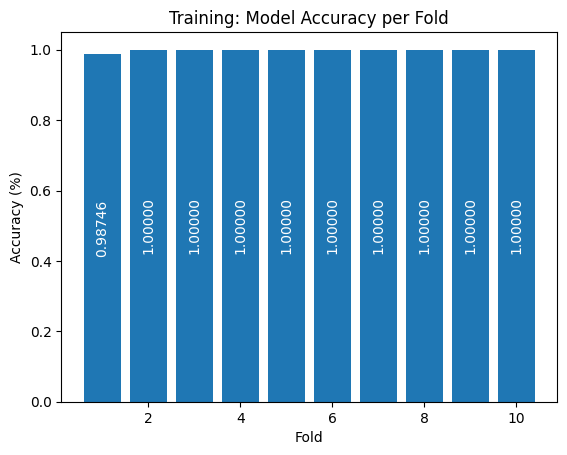

Average Accuracy: 0.99875


In [8]:
# Plot the model accuracy per fold

# Create a bar chart
fig, ax = plt.subplots()
bars = ax.bar(range(1, len(model_scores) + 1), model_scores)

# Display the accuracy value on each bar
for bar in bars:
    x_position = bar.get_x() + bar.get_width() / 2
    height = bar.get_height()
    y_position = height / 2
    label = f'{height:.5f}'
    
    ax.text(x_position, y_position,
            label, ha='center', va='center',
            rotation=90, color='white')
    
# Add labels and title
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Training: Model Accuracy per Fold')

# Display the plot
plt.show()

# Print the average accuracy for all folds
average_accuracy = round(sum(model_scores) / len(model_scores), 5)
print(f"Average Accuracy: {average_accuracy:0.5f}")



## Testing

In [9]:
# Predict for multiple samples using batch processing

testData = ["FREE entry to a fun contest",
            "Yup I will come over",
            "Buy one puppy, get one free"]

# Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(testData).toarray()

# Make predictions using the model
rawPrediction=model.predict(predict_tfidf)                  # % probability for each class
prediction=np.argmax(model.predict(predict_tfidf), axis=1)  # Index of the closest match

# Print the final predicted classifications for the test data
print("\nPredicted Classes are:\n\n", label_encoder.inverse_transform(prediction))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Predicted Classes are:

 ['spam' 'ham' 'ham']


## Save the Model and Vectorizer

All training models and their vectorizers will be automatically saved to the *"Training Models"* folder. The final, trained model and its vectorizer will be added to the *"Resources"* folder.

In [10]:
# Save the training model and vectorizer for future use
# Format: basename = type_average_accuracy_epochs_batchSize_hiddenLayers_nodes_activation_output_validation
baseName = f'Training Models/{MODEL_TYPE}_{average_accuracy:.5f}_{EPOCHS}'
baseName += f'_{BATCH_SIZE}_{NUM_HIDDEN_LAYERS}_{NUM_NODES}'
baseName += f'_{HIDDEN_LAYER_ACTIVATION}_{OUTPUT_LAYER_ACTIVATION}'

modelName = baseName + '.keras'
model.save(modelName)

vectorizerName = baseName + '.pkl'
with open(vectorizerName, 'wb') as file:
    pickle.dump(vectorizer, file)

For validation purposes, reload the saved model and vectorizer and display their properties.

In [11]:
# Loading a Model 
loaded_model = tf.keras.models.load_model(modelName)

# Loading a Vectorizer
with open(vectorizerName, 'rb') as file:
    loaded_vectorizer = pickle.load(file)

# Print Model Summary
loaded_model.summary()

# Print the loaded vectorizer
print(loaded_vectorizer)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Hidden-Layer-1 (Dense)               │ (None, 64)                  │         565,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,696,904 (6.47 MB)

 Trainable params: 565,634 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,131,270 (4.32 MB)

TfidfVectorizer(tokenizer=<bound method Custom_Tokenizer.custom_tokenizer of <Resources.CustomTokenizer.Custom_Tokenizer object at 0x000001532A8D4050>>)
